In [2]:
# Required libraries
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Regression

In [2]:
# Load dataset
df = pd.read_csv('../datasets/StarCraftData/SkillCraft1_Dataset_preprocessed.csv')

In [3]:
df.head()

Unnamed: 0  GameID  LeagueIndex  Age  HoursPerWeek  TotalHours       APM  \
0        1080    3104            1   16            20          20  103.0962   
1        3155    8755            1   30            12         150   25.4442   
2         361    1074            1   22            16         400   38.3274   
3        1564    4517            1   31            12         200   41.5860   
4        1559    4510            1   25             4          50   43.2744   

   SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  ...  MinimapRightClicks  \
0         0.000659         0.000233              5  ...            0.000000   
1         0.000385         0.000160              3  ...            0.000064   
2         0.000000         0.000000              0  ...            0.000085   
3         0.001058         0.000169              5  ...            0.000044   
4         0.000824         0.000197              5  ...            0.000066   

   NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
0      0.002909         56.0000        70.7733        6.5289   
1      0.000994        113.2000       165.1613        4.3548   
2      0.002578         76.0667        88.6281        2.8430   
3      0.001724        130.2176       122.0206        4.0825   
4      0.002626         67.5320       103.3000        2.9083   

   TotalMapExplored  WorkersMade  UniqueUnitsMade  ComplexUnitsMade  \
0                29     0.000905                6               0.0   
1                 7     0.000385                2               0.0   
2                16     0.000618                3               0.0   
3                25     0.000622                5               0.0   
4                16     0.000226                9               0.0   

   ComplexAbilitiesUsed  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 21 columns]

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   int64  
 3   HoursPerWeek          3395 non-null   int64  
 4   TotalHours            3395 non-null   int64  
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

Divide the dataframe into a set of sampled and target values

In [6]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

Scale it

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

scaller = StandardScaler()

df_scaled = scaller.fit_transform(df.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
scaller.fit(X_train)

X_train = scaller.transform(X_train)
X_test = scaller.transform(X_test)

## Let's look for anomalies

<AxesSubplot:>

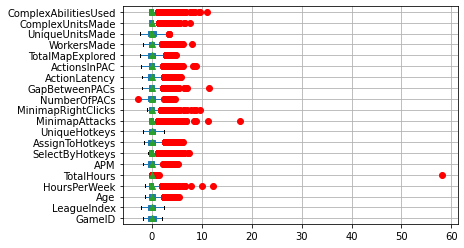

In [8]:
df = pd.DataFrame(data=df_scaled, columns=df.columns)
df.boxplot(sym='r',vert=False,patch_artist=True,meanline=False,showmeans=True)

## Boosting

In [9]:
!pip install --user catboost
!pip install --user ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [10]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

params = {
    'iterations': 19,
    'learning_rate': 1,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True
}

k = 5   # 5-fold

kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_scaled): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

model = CatBoostRegressor(**params)
    
for j in range(k):
            
    x_train = df[df.columns[2:]].loc[list_of_train_index[j], :]
    x_test = df[df.columns[2:]].loc[list_of_test_index[j], :]
    
    y_true_train = df[df.columns[1]][list_of_train_index[j]]
    y_true_test = df[df.columns[1]][list_of_test_index[j]]
    
    model.fit(X=x_train, y=y_true_train, eval_set=(x_test, y_true_test))
    
    print("Fold:{}\n R2:{}\t MSE: {}\n RMSE: {}\t MAE: {}".format(j+1, r2_score(y_true_test, model.predict(x_test)), mean_squared_error(y_true_test, model.predict(x_test)),
      mean_squared_error(y_true_test, model.predict(x_test), squared=True), mean_absolute_error(y_true_test, model.predict(x_test))))

Fold:1
 R2:0.537020182794994	 MSE: 0.4909404624751938
 RMSE: 0.4909404624751938	 MAE: 0.5616317971013502
Fold:2
 R2:0.5640342571114281	 MSE: 0.395873761710861
 RMSE: 0.395873761710861	 MAE: 0.492928950281294
Fold:3
 R2:0.5798468529810235	 MSE: 0.4122685632106307
 RMSE: 0.4122685632106307	 MAE: 0.5114044337260478
Fold:4
 R2:0.5650151095311244	 MSE: 0.4551600808759126
 RMSE: 0.4551600808759126	 MAE: 0.5304112186946073
Fold:5
 R2:0.5585427021567837	 MSE: 0.4390821313656747
 RMSE: 0.4390821313656747	 MAE: 0.5304289973162308


#### Upgrade: Possible improvement of error functionals when using stratified sampling for certain columns

Obviously, continuously differentiable functionals show the best result.


## Bagging

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [12]:
bagging_grid = {
    "max_samples": [0.05, 0.1, 0.2, 0.5],
    "max_features": [0.5, 1.0],
    "bootstrap": [True, False],
    "bootstrap_features": [True, False],
    }

for base_estimator in [None, DummyRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(), SVR()]:
    bagging_reg = GridSearchCV(
        BaggingRegressor(base_estimator=base_estimator, random_state=42, n_estimators=40), 
        param_grid=bagging_grid, verbose=0).fit(X_train, y_train)
    y_pred = bagging_reg.predict(X_test)
    print("Base:{}\n R2:{}\t MSE: {}\n RMSE: {}\t MAE: {}".format(base_estimator.__class__.__name__, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred, squared=True), mean_absolute_error(y_test, y_pred)))

Base:NoneType
 R2:0.62896203348494	 MSE: 0.8708163640824338
 RMSE: 0.8708163640824338	 MAE: 0.7459028459273799
Base:DummyRegressor
 R2:-0.004651602086848339	 MSE: 2.357890928294939
 RMSE: 2.357890928294939	 MAE: 1.2639591433646786
Base:DecisionTreeRegressor
 R2:0.62896203348494	 MSE: 0.8708163640824338
 RMSE: 0.8708163640824338	 MAE: 0.7459028459273799
Base:KNeighborsRegressor
 R2:0.5696824816393558	 MSE: 1.0099439156035328
 RMSE: 1.0099439156035328	 MAE: 0.8078312070657508
Base:SVR
 R2:0.5709437345767034	 MSE: 1.0069837880796428
 RMSE: 1.0069837880796428	 MAE: 0.7988541802899352


## Stacking

Apply cross-validation to the models and make lists of predictions for each model

0.3 - the test part of the sample && 0.7 - the training part of the sample

In [23]:
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

### CatBoost

In [49]:
sub_test_boost = 0 # Stacking Boost data
sub_train_boost = 0

k = 5 #5-Fold

kf = KFold(n_splits=k, shuffle = True, random_state = 21)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_scaled): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

model = CatBoostRegressor(iterations=100,
                            learning_rate=0.5,
                            depth=10,
                            eval_metric='RMSE',
                            random_seed = 21,
                            bagging_temperature = 0.2)
    
for j in range(k):
            
    x_train = df[df.columns[2:]].loc[list_of_train_index[j], :]
    x_test = df[df.columns[2:]].loc[list_of_test_index[j], :]
    
    y_true_train = df[df.columns[1]][list_of_train_index[j]]
    y_true_test = df[df.columns[1]][list_of_test_index[j]]
    
    model.fit(X=x_train, y=y_true_train, eval_set=(x_test, y_true_test))

    pred_test = model.predict(X_test) # !!! X_test
    sub_test_boost += pred_test
    pred_train = model.predict(X_train) # !!! X_train
    sub_train_boost += pred_train

: 0.6790984	best: 0.6598183 (7)	total: 2.41s	remaining: 893ms
73:	learn: 0.1117116	test: 0.6787272	best: 0.6598183 (7)	total: 2.44s	remaining: 859ms
74:	learn: 0.1091507	test: 0.6788045	best: 0.6598183 (7)	total: 2.47s	remaining: 825ms
75:	learn: 0.1075005	test: 0.6788366	best: 0.6598183 (7)	total: 2.5s	remaining: 791ms
76:	learn: 0.1043783	test: 0.6785121	best: 0.6598183 (7)	total: 2.54s	remaining: 759ms
77:	learn: 0.1022394	test: 0.6782167	best: 0.6598183 (7)	total: 2.58s	remaining: 728ms
78:	learn: 0.0989778	test: 0.6784523	best: 0.6598183 (7)	total: 2.62s	remaining: 696ms
79:	learn: 0.0979702	test: 0.6782665	best: 0.6598183 (7)	total: 2.65s	remaining: 662ms
80:	learn: 0.0975314	test: 0.6783882	best: 0.6598183 (7)	total: 2.68s	remaining: 628ms
81:	learn: 0.0950914	test: 0.6782047	best: 0.6598183 (7)	total: 2.71s	remaining: 594ms
82:	learn: 0.0933597	test: 0.6783838	best: 0.6598183 (7)	total: 2.74s	remaining: 561ms
83:	learn: 0.0918078	test: 0.6783085	best: 0.6598183 (7)	total: 2.77s

### DecisionTree

In [50]:
sub_test_dec = 0 # Stacking Dec data
sub_train_dec = 0

k = 5 #5-Fold

kf = KFold(n_splits=k, shuffle = True, random_state = 21)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_scaled): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

dec_tree = DecisionTreeRegressor(random_state=42, max_leaf_nodes=10, min_samples_split=4)
    
for j in range(k):
            
    x_train = df[df.columns[2:]].loc[list_of_train_index[j], :]
    x_test = df[df.columns[2:]].loc[list_of_test_index[j], :]
    
    y_true_train = df[df.columns[1]][list_of_train_index[j]]
    y_true_test = df[df.columns[1]][list_of_test_index[j]]
    
    dec_tree.fit(X=x_train, y=y_true_train)

    pred_test = dec_tree.predict(X_test) # !!! X_test
    sub_test_dec += pred_test
    pred_train = dec_tree.predict(X_train) # !!! X_train
    sub_train_dec += pred_train

### KNeighbor

In [51]:
sub_test_kneighbor = 0 # Stacking data
sub_train_kneighbor = 0

kneighbor = KNeighborsRegressor(n_neighbors=7, metric='manhattan')

k = 5 #5-Fold

kf = KFold(n_splits=k, shuffle = True, random_state = 21)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_scaled): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

kneighbor = DecisionTreeRegressor(random_state=42, max_leaf_nodes=10, min_samples_split=4)
    
for j in range(k):
            
    x_train = df[df.columns[2:]].loc[list_of_train_index[j], :]
    x_test = df[df.columns[2:]].loc[list_of_test_index[j], :]
    
    y_true_train = df[df.columns[1]][list_of_train_index[j]]
    y_true_test = df[df.columns[1]][list_of_test_index[j]]
    
    kneighbor.fit(X=x_train, y=y_true_train)

    pred_test = kneighbor.predict(X_test) # !!! X_test
    sub_test_kneighbor += pred_test
    pred_train = kneighbor.predict(X_train) # !!! X_train
    sub_train_kneighbor += pred_train

### Stack

In [55]:
stack_df = pd.DataFrame()
stack_df['dec'] = sub_train_dec
stack_df['kneighbor'] = sub_train_kneighbor
stack_df['cat'] = sub_train_boost

In [56]:
stack_test_df = pd.DataFrame()
stack_test_df['dec'] = sub_test_dec
stack_test_df['kneighbor'] = sub_test_kneighbor
stack_test_df['cat'] = sub_test_boost

In [57]:
model = Ridge().fit(stack_df.values, y_train)
pred = model.predict(stack_test_df)

Estimate the resulting model

In [58]:
print("R2:{}\t MSE: {}\n RMSE: {}\t MAE: {}".format(r2_score(y_test, pred), mean_squared_error(y_test, pred),
    mean_squared_error(y_test, pred, squared=True), mean_absolute_error(y_test, pred)))

R2:0.7420137093088124	 MSE: 0.6054870496216328
 RMSE: 0.6054870496216328	 MAE: 0.6180755772086546


Thus it can be seen that the model made on the basis of the estimates of other models is much better at guessing the required values than each separately

If the models are chosen incorrectly the the result may be worse than a separate model

# Classification

In [109]:
df_clf = pd.read_csv('../datasets/ILPD/Indian_Liver_Patient_Data_preprocessed.csv')

In [110]:
df_clf.head()

Unnamed: 0  Age    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB    AG  Disease  \
0           0   62  10.9  5.5      699    64   100  7.5  3.2  0.74        1   
1           1   62   7.3  4.1      490    60    68  7.0  3.3  0.89        1   
2           2   58   1.0  0.4      182    14    20  6.8  3.4  1.00        1   
3           3   72   3.9  2.0      195    27    59  7.3  2.4  0.40        1   
4           4   46   1.8  0.7      208    19    14  7.6  4.4  1.30        1   

   g_Female  g_Male  
0         0       1  
1         0       1  
2         0       1  
3         0       1  
4         0       1

In [111]:
df_clf = df_clf.drop('Unnamed: 0', axis=1)

In [112]:
df_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       578 non-null    int64  
 1   TB        578 non-null    float64
 2   DB        578 non-null    float64
 3   Alkphos   578 non-null    int64  
 4   Sgpt      578 non-null    int64  
 5   Sgot      578 non-null    int64  
 6   TP        578 non-null    float64
 7   ALB       578 non-null    float64
 8   AG        578 non-null    float64
 9   Disease   578 non-null    int64  
 10  g_Female  578 non-null    int64  
 11  g_Male    578 non-null    int64  
dtypes: float64(5), int64(7)
memory usage: 54.3 KB


Divide the dataframe into a set of sampled and target values

In [113]:
y = df_clf.Disease
X = df_clf.drop('Disease', axis=1)

In [114]:
X_non_categorical = df_clf.drop(df_clf.columns[-3:], axis=1)
X_non_categorical

Age    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB    AG
0     62  10.9  5.5      699    64   100  7.5  3.2  0.74
1     62   7.3  4.1      490    60    68  7.0  3.3  0.89
2     58   1.0  0.4      182    14    20  6.8  3.4  1.00
3     72   3.9  2.0      195    27    59  7.3  2.4  0.40
4     46   1.8  0.7      208    19    14  7.6  4.4  1.30
..   ...   ...  ...      ...   ...   ...  ...  ...   ...
573   60   0.5  0.1      500    20    34  5.9  1.6  0.37
574   40   0.6  0.1       98    35    31  6.0  3.2  1.10
575   52   0.8  0.2      245    48    49  6.4  3.2  1.00
576   31   1.3  0.5      184    29    32  6.8  3.4  1.00
577   38   1.0  0.3      216    21    24  7.3  4.4  1.50

[578 rows x 9 columns]

In [115]:
cat_features = list(range(9, 11))
print(cat_features)

[9, 10]


Scale non-categorical features

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaller = StandardScaler()

X_columns = np.hstack([df_clf.columns[:-3], df_clf.columns[-2:]])

X_non_categorical = scaller.fit_transform(X_non_categorical.values)

X_data = np.hstack([X_non_categorical, X[df_clf.columns[-2:]].values])

X = pd.DataFrame(data=X_data, columns=X_columns)

X[df_clf.columns[-2:]] = df_clf[df_clf.columns[-2:]].astype('int64', copy=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Look for anomalies

In [117]:
X['Disease'] = df_clf.Disease 
df_clf_scaled = X

<AxesSubplot:>

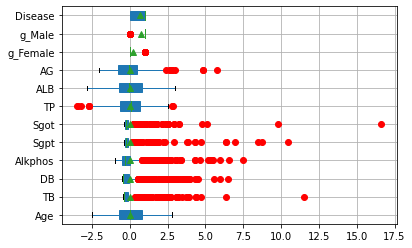

In [118]:
df_clf = pd.DataFrame(data=df_clf_scaled, columns=df_clf_scaled.columns)
df_clf.boxplot(sym='r',vert=False,patch_artist=True,meanline=False,showmeans=True)

In [119]:
df_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       578 non-null    float64
 1   TB        578 non-null    float64
 2   DB        578 non-null    float64
 3   Alkphos   578 non-null    float64
 4   Sgpt      578 non-null    float64
 5   Sgot      578 non-null    float64
 6   TP        578 non-null    float64
 7   ALB       578 non-null    float64
 8   AG        578 non-null    float64
 9   g_Female  578 non-null    int64  
 10  g_Male    578 non-null    int64  
 11  Disease   578 non-null    int64  
dtypes: float64(9), int64(3)
memory usage: 54.3 KB


## Boosting

In [124]:
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

params = {
    'iterations': 21,
    'learning_rate': 1,
    'eval_metric': 'AUC',
    'random_seed': 21,
    'logging_level': 'Silent',
    'use_best_model': True
}

k = 5   # 5-fold

kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_clf): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

model = CatBoostClassifier(**params, cat_features=list(range(9, 11)))
    
for j in range(k):
            
    x_train = df_clf[df_clf.columns[:-1]].loc[list_of_train_index[j], :]
    x_test = df_clf[df_clf.columns[:-1]].loc[list_of_test_index[j], :]
    
    y_true_train = df_clf[df_clf.columns[11]][list_of_train_index[j]]
    y_true_test = df_clf[df_clf.columns[11]][list_of_test_index[j]]
    
    model.fit(X=x_train, y=y_true_train, eval_set=(x_test, y_true_test))

    y_pred = model.predict(X_test)
    
    print("Fold: {}\n Confusion:\n{}\n clf_report:{}\n".format(j+1,
    confusion_matrix(y_test, y_pred), 
    classification_report(y_test, y_pred)))

Fold: 1
 Confusion:
[[ 23  30]
 [  8 113]]
 clf_report:              precision    recall  f1-score   support

           0       0.74      0.43      0.55        53
           1       0.79      0.93      0.86       121

    accuracy                           0.78       174
   macro avg       0.77      0.68      0.70       174
weighted avg       0.78      0.78      0.76       174


Fold: 2
 Confusion:
[[ 32  21]
 [ 14 107]]
 clf_report:              precision    recall  f1-score   support

           0       0.70      0.60      0.65        53
           1       0.84      0.88      0.86       121

    accuracy                           0.80       174
   macro avg       0.77      0.74      0.75       174
weighted avg       0.79      0.80      0.79       174


Fold: 3
 Confusion:
[[ 37  16]
 [ 11 110]]
 clf_report:              precision    recall  f1-score   support

           0       0.77      0.70      0.73        53
           1       0.87      0.91      0.89       121

    accuracy   

Boosting clf has good recalls estimate

## Bagging

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier

In [143]:
bagging_grid = {
    "max_samples": [0.05, 0.1, 0.2, 0.5],
    "max_features": [0.5, 1.0],
    "bootstrap": [True, False],
    "bootstrap_features": [True, False],
    }

for base_estimator in [None, DecisionTreeClassifier(), SGDClassifier()]:
    bagging_clf = GridSearchCV(
        BaggingClassifier(base_estimator=base_estimator, random_state=42, n_estimators=40), 
        param_grid=bagging_grid, verbose=0).fit(X_train, y_train)
    y_pred = bagging_clf.predict(X_test)
    print("Base:{}\n Confusion:\n{}\n clf_report:{}\n".format(base_estimator.__class__.__name__,
        confusion_matrix(y_test, y_pred), 
        classification_report(y_test, y_pred)))

Base:NoneType
 Confusion:
[[ 11  42]
 [ 12 109]]
 clf_report:              precision    recall  f1-score   support

           0       0.48      0.21      0.29        53
           1       0.72      0.90      0.80       121

    accuracy                           0.69       174
   macro avg       0.60      0.55      0.55       174
weighted avg       0.65      0.69      0.65       174


Base:DecisionTreeClassifier
 Confusion:
[[ 11  42]
 [ 12 109]]
 clf_report:              precision    recall  f1-score   support

           0       0.48      0.21      0.29        53
           1       0.72      0.90      0.80       121

    accuracy                           0.69       174
   macro avg       0.60      0.55      0.55       174
weighted avg       0.65      0.69      0.65       174


Base:SGDClassifier
 Confusion:
[[  2  51]
 [  3 118]]
 clf_report:              precision    recall  f1-score   support

           0       0.40      0.04      0.07        53
           1       0.70      0.98

## Stacking

### DecisionTree

In [146]:
sub_test_dec = 0 # Stacking Dec data
sub_train_dec = 0

k = 5 #5-Fold

kf = KFold(n_splits=k, shuffle = True, random_state = 21)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_clf): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

dec_tree = DecisionTreeClassifier(random_state=42, max_leaf_nodes=10, min_samples_split=4)
    
for j in range(k):
            
    x_train = df_clf[df_clf.columns[:-1]].loc[list_of_train_index[j], :]
    x_test = df_clf[df_clf.columns[:-1]].loc[list_of_test_index[j], :]
    
    y_true_train = df_clf[df_clf.columns[11]][list_of_train_index[j]]
    y_true_test = df_clf[df_clf.columns[11]][list_of_test_index[j]]
    
    dec_tree.fit(X=x_train, y=y_true_train)

    pred_test = dec_tree.predict(X_test) # !!! X_test
    sub_test_dec += pred_test
    pred_train = dec_tree.predict(X_train) # !!! X_train
    sub_train_dec += pred_train

### SGD

In [150]:
sub_test_sgd = 0 # Stacking Dec data
sub_train_sgd = 0

k = 5 #5-Fold

kf = KFold(n_splits=k, shuffle = True, random_state = 21)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_clf): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

sgd_clf = SGDClassifier(random_state=21, alpha=1e1, n_iter_no_change=500, penalty='l2')
    
for j in range(k):
            
    x_train = df_clf[df_clf.columns[:-1]].loc[list_of_train_index[j], :]
    x_test = df_clf[df_clf.columns[:-1]].loc[list_of_test_index[j], :]
    
    y_true_train = df_clf[df_clf.columns[11]][list_of_train_index[j]]
    y_true_test = df_clf[df_clf.columns[11]][list_of_test_index[j]]
    
    sgd_clf.fit(X=x_train, y=y_true_train)

    pred_test = sgd_clf.predict(X_test) # !!! X_test
    sub_test_sgd += pred_test
    pred_train = sgd_clf.predict(X_train) # !!! X_train
    sub_train_sgd += pred_train

### CatBoost

In [154]:
sub_test_boost = 0 # Stacking Boost data
sub_train_boost = 0

k = 5 #5-Fold

kf = KFold(n_splits=k, shuffle = True, random_state = 21)
    
list_of_train_index = []
list_of_test_index = []

for train_index, test_index in kf.split(df_clf): # True input
    
    list_of_train_index.append(train_index)
    list_of_test_index.append(test_index)
    
# Use indexes for cross-validation

model = CatBoostClassifier(iterations=100,
                            learning_rate=0.5,
                            depth=10,
                            eval_metric='AUC',
                            random_seed = 21,
                            bagging_temperature = 0.2,
                            cat_features=list(range(9, 11)))
    
for j in range(k):
            
    x_train = df_clf[df_clf.columns[:-1]].loc[list_of_train_index[j], :]
    x_test = df_clf[df_clf.columns[:-1]].loc[list_of_test_index[j], :]
    
    y_true_train = df_clf[df_clf.columns[11]][list_of_train_index[j]]
    y_true_test = df_clf[df_clf.columns[11]][list_of_test_index[j]]
    
    model.fit(X=x_train, y=y_true_train, eval_set=(x_test, y_true_test))

    pred_test = model.predict(X_test) # !!! X_test
    sub_test_boost += pred_test
    pred_train = model.predict(X_train) # !!! X_train
    sub_train_boost += pred_train

tal: 290ms	remaining: 1.23s
19:	test: 0.7465116	best: 0.7693798 (8)	total: 303ms	remaining: 1.21s
20:	test: 0.7500000	best: 0.7693798 (8)	total: 314ms	remaining: 1.18s
21:	test: 0.7527132	best: 0.7693798 (8)	total: 325ms	remaining: 1.15s
22:	test: 0.7534884	best: 0.7693798 (8)	total: 336ms	remaining: 1.12s
23:	test: 0.7480620	best: 0.7693798 (8)	total: 345ms	remaining: 1.09s
24:	test: 0.7480620	best: 0.7693798 (8)	total: 356ms	remaining: 1.07s
25:	test: 0.7538760	best: 0.7693798 (8)	total: 366ms	remaining: 1.04s
26:	test: 0.7562016	best: 0.7693798 (8)	total: 376ms	remaining: 1.02s
27:	test: 0.7550388	best: 0.7693798 (8)	total: 387ms	remaining: 996ms
28:	test: 0.7562016	best: 0.7693798 (8)	total: 398ms	remaining: 974ms
29:	test: 0.7538760	best: 0.7693798 (8)	total: 407ms	remaining: 950ms
30:	test: 0.7488372	best: 0.7693798 (8)	total: 418ms	remaining: 931ms
31:	test: 0.7511628	best: 0.7693798 (8)	total: 430ms	remaining: 914ms
32:	test: 0.7550388	best: 0.7693798 (8)	total: 443ms	remaining

### Stack

In [155]:
stack_df = pd.DataFrame()
stack_df['dec'] = sub_train_dec
stack_df['sgd'] = sub_train_sgd
stack_df['cat'] = sub_train_boost

In [156]:
stack_test_df = pd.DataFrame()
stack_test_df['dec'] = sub_test_dec
stack_test_df['sgd'] = sub_test_sgd
stack_test_df['cat'] = sub_test_boost

In [158]:
from sklearn.linear_model import Ridge

In [159]:
model = Ridge().fit(stack_df.values, y_train)
pred = model.predict(stack_test_df)

Estimate the resulting model

In [160]:
print("Confusion:\n{}\n clf_report:{}\n".format(
    confusion_matrix(y_test, y_pred), 
    classification_report(y_test, y_pred)))

Confusion:
[[  2  51]
 [  3 118]]
 clf_report:              precision    recall  f1-score   support

           0       0.40      0.04      0.07        53
           1       0.70      0.98      0.81       121

    accuracy                           0.69       174
   macro avg       0.55      0.51      0.44       174
weighted avg       0.61      0.69      0.59       174




The result can be better if the anomalies are eliminated